# COVID-19 Research Papers Clustering Analysis

This notebook performs clustering analysis on COVID-19 research papers using natural language processing
and machine learning techniques. The analysis includes:
1. Data loading and preprocessing
2. Exploratory Data Analysis (EDA)
3. Feature extraction using TF-IDF
4. Dimensionality reduction using PCA
5. Clustering using K-means
6. Visualization using t-SNE

The goal is to identify distinct research themes and patterns in COVID-19 literature.

`Author: Pourya`

`Date: 2024-11-11`

In [1]:
# Import necessary libraries
from typing import List, Tuple, Dict, Optional, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import warnings

In [2]:
# Set plotting style and configure warnings
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

In [3]:
# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
def load_and_preprocess_data(
    file_path: str,
    sample_size: Optional[int] = 5000,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Load and preprocess the COVID-19 research papers metadata.

    Args:
        file_path (str): Path to the metadata CSV file
        sample_size (Optional[int]): Number of samples to use (None for full dataset)
        random_state (int): Random state for reproducibility

    Returns:
        pd.DataFrame: Preprocessed DataFrame containing paper information
    """
    # Load data with appropriate dtypes
    meta_df = pd.read_csv(file_path, dtype={
        'pubmed_id': str,
        'Microsoft Academic Paper ID': str,
        'doi': str
    })

    # Select relevant columns and create new DataFrame
    columns_of_interest = ['sha', 'doi', 'title', 'abstract', 'authors', 'journal']
    df_covid = pd.DataFrame({
        'paper_id': meta_df['sha'],
        'doi': meta_df['doi'],
        'title': meta_df['title'],
        'abstract': meta_df['abstract'],
        'authors': meta_df['authors'],
        'journal': meta_df['journal']
    })

    # Clean data: fill NaN values and sample if specified
    df_covid.fillna('', inplace=True)
    if sample_size:
        df_covid = df_covid.sample(sample_size, random_state=random_state)

    return df_covid

In [5]:
def perform_eda(df: pd.DataFrame) -> None:
    """
    Perform Exploratory Data Analysis on the dataset.

    Args:
        df (pd.DataFrame): Input DataFrame containing paper information
    """
    print("=== Dataset Overview ===")
    print(f"Total number of papers: {len(df)}")
    print("\nMissing values:")
    print(df.isnull().sum())

    # Create visualizations for data understanding
    plt.figure(figsize=(15, 5))

    # 1. Journal distribution (top 20)
    plt.subplot(1, 2, 1)
    journal_counts = df['journal'].value_counts().head(20)
    sns.barplot(x=journal_counts.values, y=journal_counts.index)
    plt.title('Top 20 Journals')
    plt.xlabel('Number of Papers')

    # 2. Abstract length distribution
    plt.subplot(1, 2, 2)
    abstract_lengths = df['abstract'].str.len()
    sns.histplot(abstract_lengths, bins=50)
    plt.title('Abstract Length Distribution')
    plt.xlabel('Length of Abstract')

    plt.tight_layout()
    plt.show()

    # Create word cloud for abstracts
    plt.figure(figsize=(15, 8))
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color='white',
        max_words=100
    ).generate(' '.join(df['abstract'].values))

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Word Cloud of Abstract Contents')
    plt.show()

In [6]:
def vectorize_text(
    text: List[str],
    max_features: int,
    vectorizer: Optional[TfidfVectorizer] = None
) -> Tuple[np.ndarray, TfidfVectorizer]:
    """
    Convert text data to TF-IDF vectors.

    Args:
        text (List[str]): List of text documents
        max_features (int): Maximum number of features to extract
        vectorizer (Optional[TfidfVectorizer]): Existing vectorizer for transform-only

    Returns:
        Tuple[np.ndarray, TfidfVectorizer]: TF-IDF matrix and vectorizer
    """
    if vectorizer is None:
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            stop_words='english',
            ngram_range=(1, 2)
        )
        X = vectorizer.fit_transform(text)
    else:
        X = vectorizer.transform(text)

    return X, vectorizer

In [7]:
def reduce_dimensions(
    X: np.ndarray,
    n_components: Union[int, float] = 0.95,
    random_state: int = 42
) -> np.ndarray:
    """
    Reduce dimensionality of the feature matrix using PCA.

    Args:
        X (np.ndarray): Input feature matrix
        n_components (Union[int, float]): Number of components or variance ratio to preserve
        random_state (int): Random state for reproducibility

    Returns:
        np.ndarray: Reduced feature matrix
    """
    pca = PCA(n_components=n_components, random_state=random_state)
    X_reduced = pca.fit_transform(X.toarray())

    # Plot explained variance ratio
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    return X_reduced

In [8]:
def find_optimal_clusters(
    X: np.ndarray,
    k_range: range,
    random_state: int = 42
) -> List[float]:
    """
    Find optimal number of clusters using the elbow method.

    Args:
        X (np.ndarray): Input feature matrix
        k_range (range): Range of k values to try
        random_state (int): Random state for reproducibility

    Returns:
        List[float]: Distortion scores for each k
    """
    distortions = []
    for k in tqdm(k_range, desc='Finding optimal k'):
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(X)
        distortions.append(
            sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
        )

    # Plot elbow curve
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, distortions, 'b-')
    plt.plot([k_range[0], k_range[-1]], [distortions[0], distortions[-1]], 'r--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.xticks(k_range)
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

    return distortions

In [9]:
def perform_clustering(
    X: np.ndarray,
    n_clusters: int,
    random_state: int = 42
) -> np.ndarray:
    """
    Perform K-means clustering on the data.

    Args:
        X (np.ndarray): Input feature matrix
        n_clusters (int): Number of clusters
        random_state (int): Random state for reproducibility

    Returns:
        np.ndarray: Cluster labels
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X)
    return labels

In [25]:
def visualize_cluster_distribution(
    labels: np.ndarray,
    save_plot: bool = True,
    random_state: int = 42
) -> None:
    """
    Visualize the distribution of papers across clusters with styled presentation.

    Args:
        labels (np.ndarray): Cluster labels
        save_plot (bool): Whether to save the plot to file
        random_state (int): Random state for reproducibility
    """
    # Set the style consistent with the notebook
    plt.style.use('seaborn-v0_8')

    # Create figure with specified size
    plt.figure(figsize=(15, 7))

    # Calculate cluster distribution
    cluster_counts = pd.Series(labels).value_counts().sort_index()

    # Create color palette similar to the cluster visualization
    n_clusters = len(np.unique(labels))
    colors = sns.hls_palette(n_clusters, l=.4, s=.9)

    # Create the bar plot
    ax = sns.barplot(
        x=cluster_counts.index,
        y=cluster_counts.values,
        palette=colors
    )

    # Customize the plot
    plt.title('Distribution of Papers Across Clusters', pad=20, size=14)
    plt.xlabel('Cluster', size=12)
    plt.ylabel('Number of Papers', size=12)

    # Add value labels on top of each bar
    for i, v in enumerate(cluster_counts.values):
        ax.text(
            i,
            v,
            str(v),
            ha='center',
            va='bottom'
        )

    # Customize grid
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Save plot if requested
    if save_plot:
        plt.savefig(
            'cluster_distribution.png',
            dpi=300,
            bbox_inches='tight'
        )

    plt.show()

In [10]:
def visualize_clusters(
    X: np.ndarray,
    labels: np.ndarray,
    perplexity: int = 50,
    random_state: int = 42
) -> None:
    """
    Visualize clusters using t-SNE with Plotly and styling similar to the original visualization.

    Args:
        X (np.ndarray): Input feature matrix
        labels (np.ndarray): Cluster labels
        perplexity (int): t-SNE perplexity parameter
        random_state (int): Random state for reproducibility
    """
    # Perform t-SNE with initialization from PCA
    print("Performing t-SNE dimensionality reduction...")
    tsne = TSNE(
        n_components=2,
        verbose=1,
        init='pca',
        perplexity=perplexity,
        n_iter=1000,
        random_state=random_state
    )
    X_embedded = tsne.fit_transform(X)

    # Create custom color palette similar to the original
    n_clusters = len(np.unique(labels))
    colors = sns.hls_palette(n_clusters, l=.4, s=.9)
    # Convert RGB colors to hex for plotly
    colors = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r,g,b in colors]

    # Create the plot using Plotly
    fig = go.Figure()

    # Add traces for each cluster
    for i in range(n_clusters):
        mask = labels == i
        fig.add_trace(go.Scatter(
            x=X_embedded[mask, 0],
            y=X_embedded[mask, 1],
            mode='markers',
            name=f'Cluster {i}',
            marker=dict(
                color=colors[i],
                size=3,
                opacity=0.8,
            ),
            showlegend=True
        ))

    fig.update_layout(
        title={
            'text': 't-SNE with Kmeans Labels',
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': dict(size=14)
        },
        width=1000,
        height=1000,
        showlegend=True,
        legend=dict(
            title='Cluster',
            yanchor="top",
            y=1,
            xanchor="left",
            x=1.02,
            font=dict(size=10)
        ),
        plot_bgcolor='rgb(241,243,246)',
        xaxis=dict(
            title='t-SNE dimension 1',
            showgrid=True,
            gridcolor='white'
        ),
        yaxis=dict(
            title='t-SNE dimension 2',
            showgrid=True,
            gridcolor='white'
        ),
        margin=dict(l=80, r=80, t=80, b=80)
    )

    fig.show()

In [13]:
# Set parameters
FILE_PATH = "/content/drive/MyDrive/ML/covid/metadata.csv"  # Update with your Google Drive path
SAMPLE_SIZE = 5000
RANDOM_STATE = 42

In [14]:
# Load and preprocess data
df = load_and_preprocess_data(FILE_PATH, SAMPLE_SIZE, RANDOM_STATE)

=== Dataset Overview ===
Total number of papers: 5000

Missing values:
paper_id    0
doi         0
title       0
abstract    0
authors     0
journal     0
dtype: int64


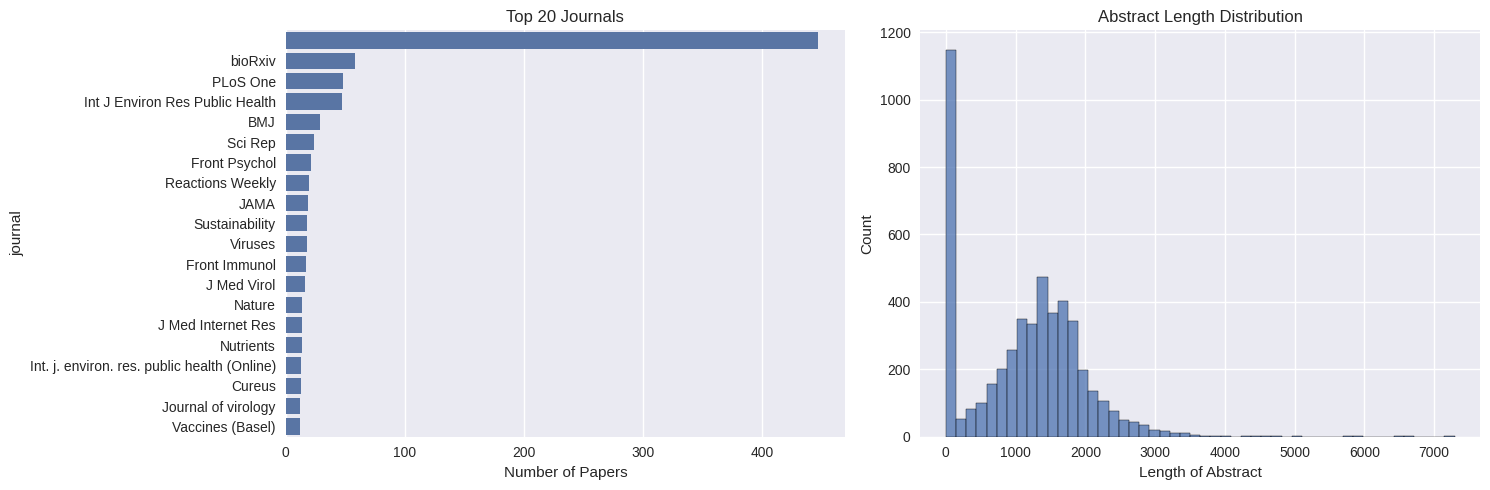

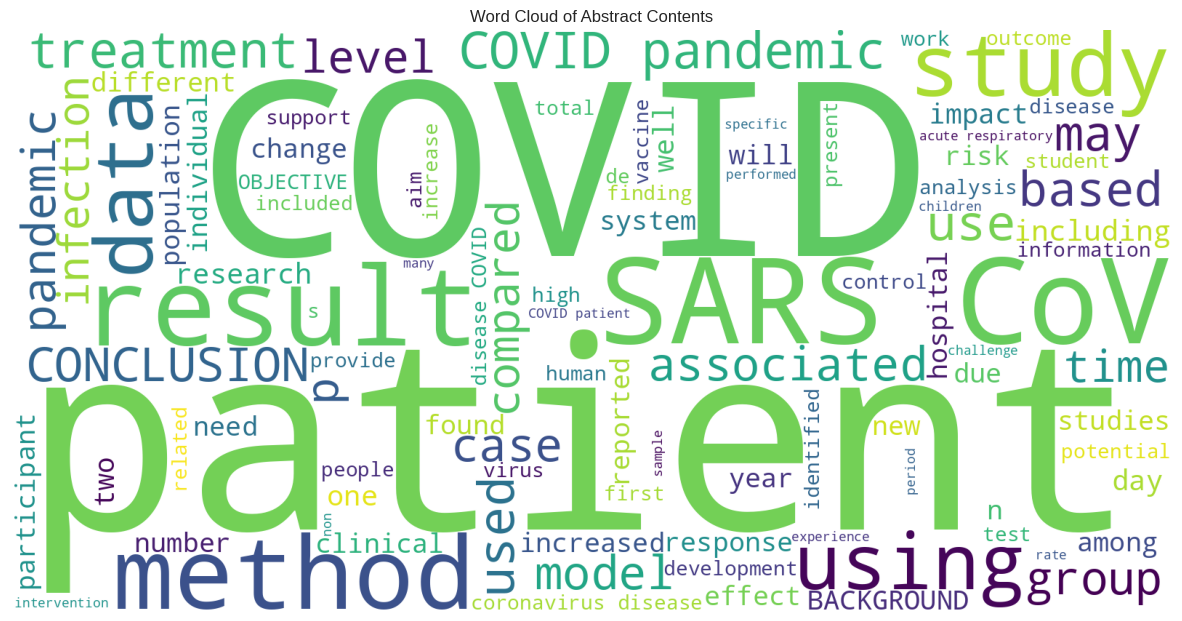

In [15]:
# Perform EDA
perform_eda(df)

In [16]:
# Feature extraction
# 1. From abstracts (primary features)
abstract_text = df['abstract'].values
X1, vectorizer1 = vectorize_text(abstract_text, max_features=2**10)

In [17]:
# 2. From journals (secondary features)
journal_text = df['journal'].values
X2, vectorizer2 = vectorize_text(journal_text, max_features=2**4)

In [18]:
# 3. From combined title and journal
combined_text = df['title'].values + df['journal'].values
X3, vectorizer3 = vectorize_text(combined_text, max_features=2**5)

In [19]:
# Use combined features (X3) as in original code
X = X3

Reducing dimensions with PCA...


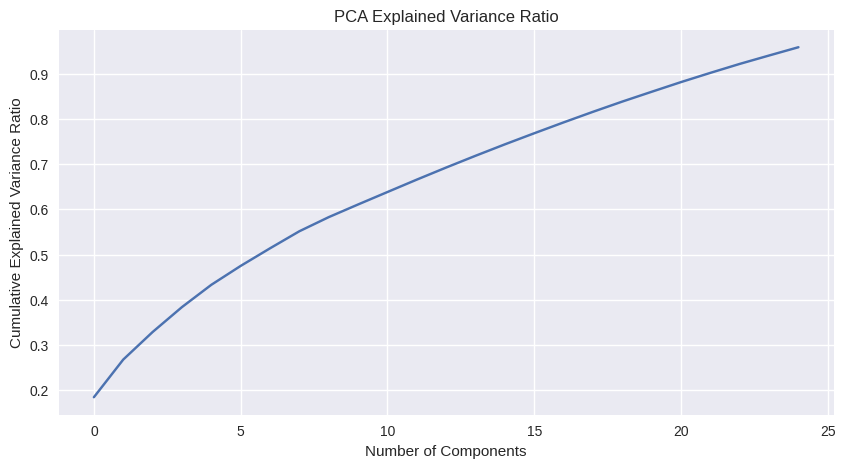

In [20]:
# Dimensionality reduction
print("Reducing dimensions with PCA...")
X_reduced = reduce_dimensions(X)

Finding optimal k:   0%|          | 0/20 [00:00<?, ?it/s]

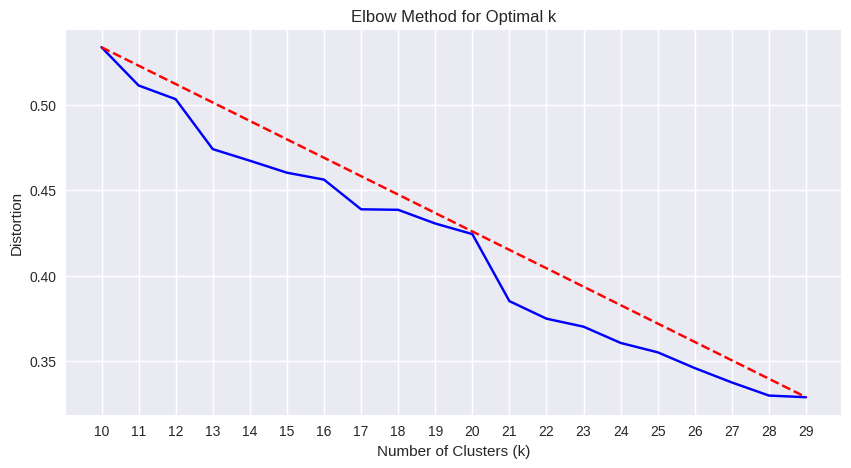

In [21]:
# Find optimal number of clusters
k_range = range(10, 30)
distortions = find_optimal_clusters(X_reduced, k_range)

In [22]:
# Perform clustering with optimal k
optimal_k = 21  # Based on elbow curve
labels = perform_clustering(X_reduced, optimal_k)

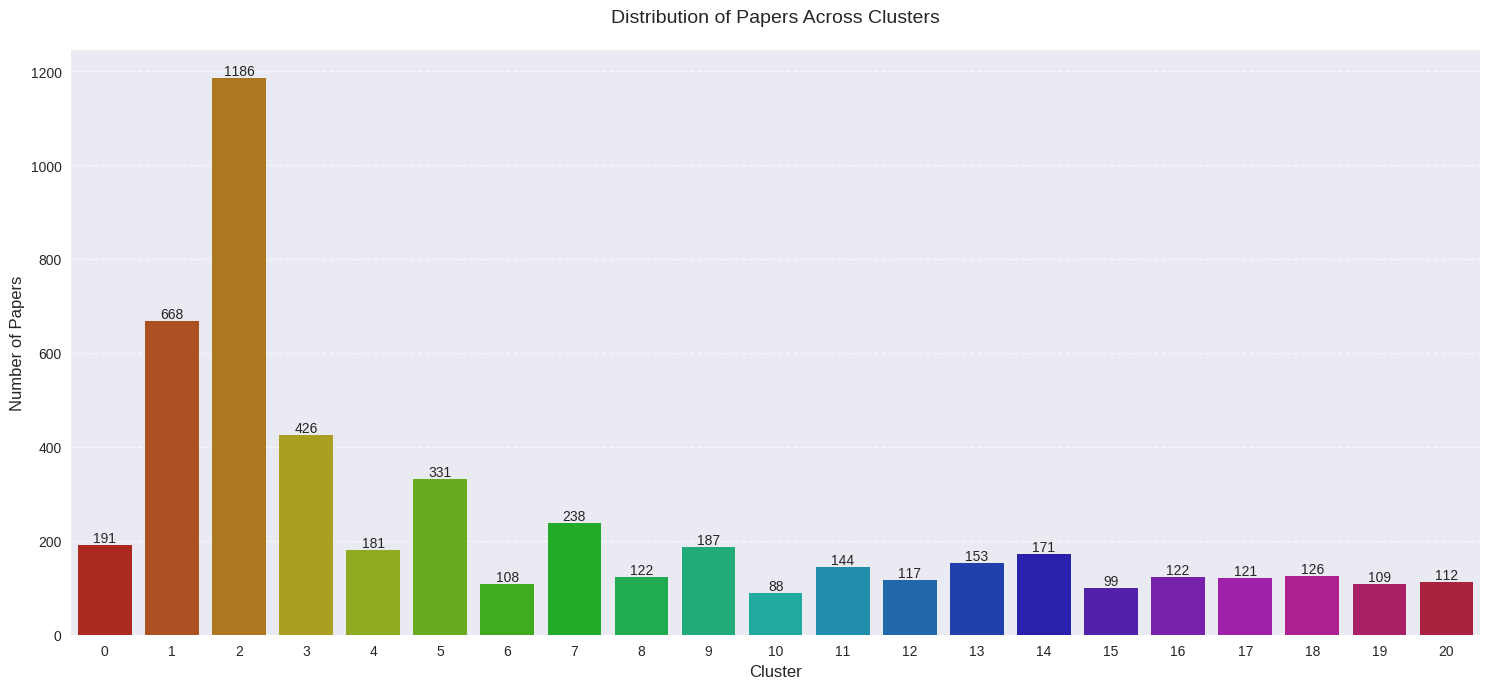

In [24]:
# Cluster distribution visualization
visualize_cluster_distribution(labels)

In [ ]:
# Visualize results
visualize_clusters(X.toarray(), labels)

Performing t-SNE dimensionality reduction...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.677s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.326012
[t-SNE] KL divergence after 1000 iterations: 0.429359


In [ ]:
# Save results
df['cluster'] = labels
df.to_csv('clustered_papers.csv', index=False)